# KNN

In [1]:
import numpy as np
import pandas as pd
import math 

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

## Importing Data

In [2]:
pwd

'/Users/stefstroke/Desktop/100/ds100finalProject/data100-final'

In [3]:
state_path = "Cleaned_state.csv"
confirmed_path = "Combined_confirmed.csv"
death_path = "Combined_deaths.csv"
data_path = "all_in_1.csv"

#states and its metadata, 
state_df = pd.read_csv(state_path)
confirmed_df = pd.read_csv(confirmed_path)
death_df = pd.read_csv(death_path)
all_in_one = pd.read_csv(data_path)


In [4]:
all_in_one.columns.values

array(['Unnamed: 0', 'Lat_x', 'Long_', '1/22/20', '1/23/20', '1/24/20',
       '1/25/20', '1/26/20', '1/27/20', '1/28/20', '1/29/20', '1/30/20',
       '1/31/20', '2/1/20', '2/2/20', '2/3/20', '2/4/20', '2/5/20',
       '2/6/20', '2/7/20', '2/8/20', '2/9/20', '2/10/20', '2/11/20',
       '2/12/20', '2/13/20', '2/14/20', '2/15/20', '2/16/20', '2/17/20',
       '2/18/20', '2/19/20', '2/20/20', '2/21/20', '2/22/20', '2/23/20',
       '2/24/20', '2/25/20', '2/26/20', '2/27/20', '2/28/20', '2/29/20',
       '3/1/20', '3/2/20', '3/3/20', '3/4/20', '3/5/20', '3/6/20',
       '3/7/20', '3/8/20', '3/9/20', '3/10/20', '3/11/20', '3/12/20',
       '3/13/20', '3/14/20', '3/15/20', '3/16/20', '3/17/20', '3/18/20',
       '3/19/20', '3/20/20', '3/21/20', '3/22/20', '3/23/20', '3/24/20',
       '3/25/20', '3/26/20', '3/27/20', '3/28/20', '3/29/20', '3/30/20',
       '3/31/20', '4/1/20', '4/2/20', '4/3/20', '4/4/20', '4/5/20',
       '4/6/20', '4/7/20', '4/8/20', '4/9/20', '4/10/20', '4/11/20',
      

## mapper and metric baseline

In [12]:
data = all_in_one

In [13]:
import string

pertiles = [np.percentile(data['4/18/20'], i * 10) for i in range(1, 11)]
letters = string.ascii_uppercase

def better_mapper(x):
    for j in range(10):
        if x <= pertiles[j]:
            return letters[j]
    return letters[8]

data['status'] = data['4/18/20'].apply(better_mapper)

np.unique(data['status'], return_counts=True)



(array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'], dtype=object),
 array([438, 249, 313, 319, 252, 332, 307, 302, 314, 314]))

In [14]:
def dist_metric(loc1, loc2):
    lat1, lon1, lat2, lon2  = loc1[0], loc1[1], loc2[0], loc2[1]
    p = 0.017453292519943295 # Pi / 180
    a = 0.5 - np.cos((lat2 - lat1) * p) / 2 + np.cos(lat1 * p) * np.cos(lat2 * p) * \
    (1 - np.cos((lon2 - lon1) * p)) / 2
    return 12742 * np.arcsin(a ** 2) # 12742 = 2 * R


loc1 = [32.10030533, -85.71265535]
loc2 = [31.75300095, -86.68057478]

dist_metric(loc1, loc2)


4.675820450994429e-05

In [15]:
data['status'].head()

0    G
1    I
2    F
3    G
4    G
Name: status, dtype: object

## Train-test Split & Feature Matrix

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
data = all_in_one

X = data[['Lat_x', 'Long_']]
y = data[['status']]

train, test = train_test_split(data, test_size=0.20, shuffle = True)

train_X, train_y = train[['Lat_x', 'Long_']], train['4/17/20']
test_X, test_y = test[['Lat_x', 'Long_']], test['4/17/20']

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((2512, 2), (2512,), (628, 2), (628,))

Text(0.5, 1.0, 'counties by position')

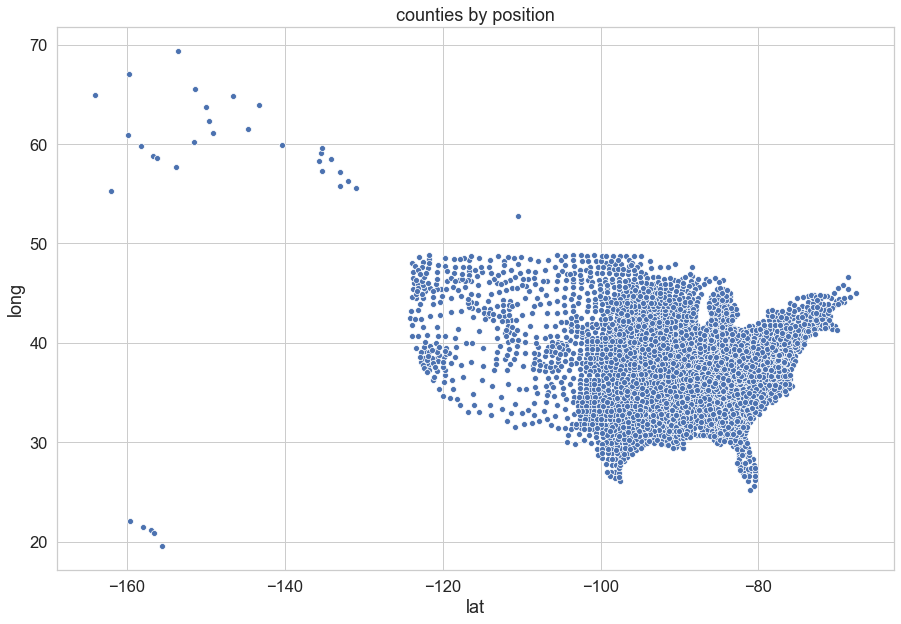

In [18]:
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.scatterplot(x="Long_", y="Lat_x", data=data)

# plt.ylim(0, 5)
# plt.setp(ax.get_legend().get_texts(), fontsize='15')
plt.xlabel('lat')
plt.ylabel('long')
plt.title('counties by position')

## KNN algorithm for prediction

### Notes on metric:

Unsupervised nearest neighbors is the foundation of many other learning methods.

The principle behind nearest neighbor methods is to find a predefined number of training samples closest in distance to the new point, and predict the label from these. 

1) The number of samples can be a **user-defined constant** (k-nearest neighbor learning), or vary based on the local density of points (radius-based neighbor learning). The distance can, in general, be any 

2) metric measure: standard Euclidean distance is the most common choice. Neighbors-based methods are known as non-generalizing machine learning methods, since they simply “remember” all of its training data (possibly transformed into a fast indexing structure such as a Ball Tree or KD Tree).

Metric example--Taxicab geometry, also known as Manhattan Distance, commonly used in regression analysis, or LASSO
$$d1(\textbf{p}, \textbf{q}) = ||\textbf{p} - \textbf{q}||_1 =\sum_{k=1}^n |p_i - q_i|$$
where p, q are vectors

Metric example--Minkowski distance, which is good for sparse matrices. $$ D(X, Y) = \sum_{k=1}^n (|x_i - y_i|^p)^\frac{1}{p}$$

### K-Means CLustering

In [19]:
from sklearn.cluster import KMeans

numCluster = 100

kmeans = KMeans(n_clusters=numCluster, random_state=0)
kmeans.fit(X)

y = kmeans.labels_

numCounty = math.ceil(X.shape[0]/numCluster)

print(y), len(y) == X.shape[0], max(y), print("number of county in each cluster is on avg " + str(numCounty))


[83 83 62 ... 99 30 96]
number of county in each cluster is on avg 32


(None, True, 99, None)

In [20]:
# predict which cluster a newly given point belongs to 
print(kmeans.predict([[32, -86], [33, -83]]))

[83 67]


99

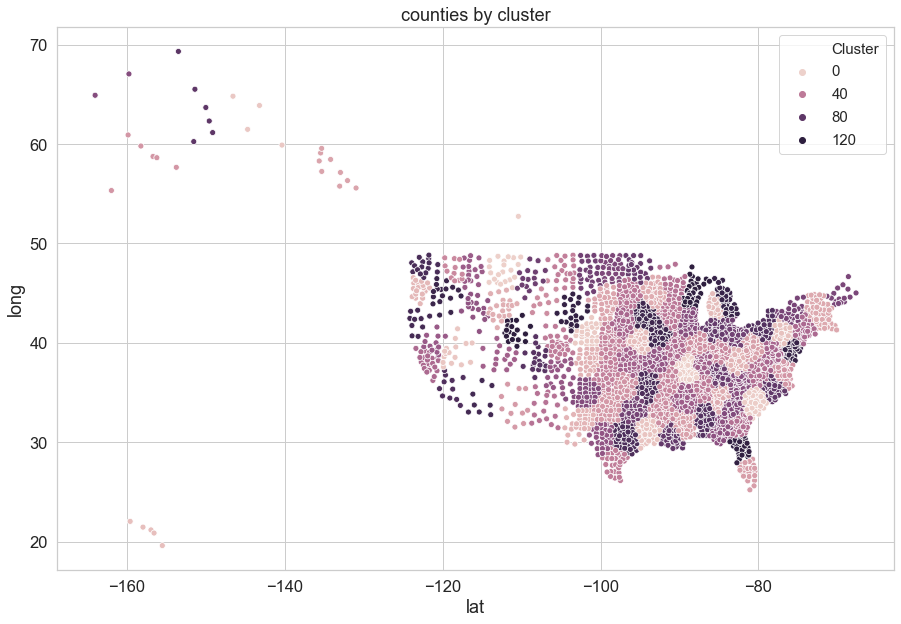

In [21]:
df = df = np.c_[X, kmeans.labels_]

fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.scatterplot(x="X", y="Y", hue = 'Cluster', data=pd.DataFrame(df, columns=['Y', 'X', 'Cluster']), )


# plt.ylim(0, 5)
plt.setp(ax.get_legend().get_texts(), fontsize='15')
plt.xlabel('lat')
plt.ylabel('long')
plt.title('counties by cluster')

np.max(kmeans.labels_)


In [22]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://upload.wikimedia.org/wikipedia/commons/thumb/9/92/Map_of_USA_with_state_names_2.svg/550px-Map_of_USA_with_state_names_2.svg.png", width=500)


array([[  37.19513088,  -88.98770632],
       [  47.48028931, -112.21911903],
       [  34.07457508,  -80.48377121],
       [  40.91365697, -101.52009669],
       [  62.51254797, -143.71371387]])

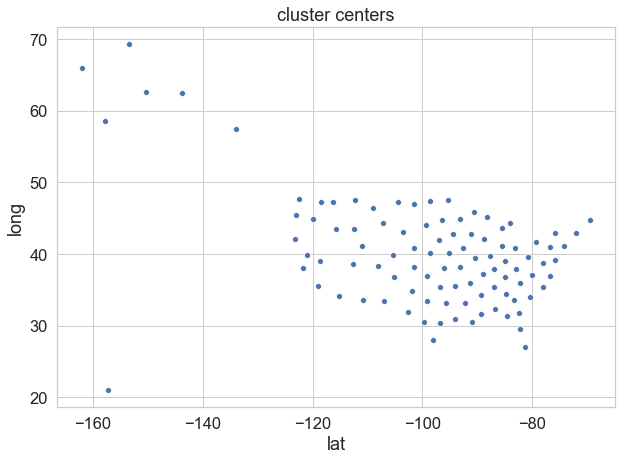

In [23]:
fig, ax = plt.subplots(figsize=(10, 7))
ax = sns.scatterplot(x="X", y="Y", data=pd.DataFrame(kmeans.cluster_centers_, columns=['Y', 'X']))

# plt.ylim(0, 5)
# plt.setp(ax.get_legend().get_texts(), fontsize='15')
plt.xlabel('lat')
plt.ylabel('long')
plt.title('cluster centers')

kmeans.cluster_centers_[0:5]


## KNN algorithm for prediction

### model

In [24]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights="distance", metric=dist_metric)


In [34]:
knn_clf.fit(train_X, train_y)

# np.sum(train_Y == knn_clf.predict(train_X))


ValueError: could not convert string to float: 'F'

2512

In [28]:
len(train_X)

2512

In [32]:
train_X.head()

,Lat_x,Long_,fitted,real
1908,35.134926,-84.059709,F,F
2306,41.649385,-75.299565,I,I
1935,35.018883,-79.236517,G,G
2767,29.173260,-98.086931,F,F
2360,34.972815,-81.180859,I,I


In [ ]:
train_acc = np.sum(train_X['fitted'] == train_X['real']) / len(train_X)
train_acc = np.sum(train_X['fitted'] == train_X['real']) / len(train_X)

train_acc

In [10]:
knn_clf2 = KNeighborsClassifier(metric=dist_metric)

knn_clf2.fit(train_covid[['Lat', 'Long_']], train_y)
test_covid['predicted2'] = knn_clf2.predict(test_X)

NameError: name 'KNeighborsClassifier' is not defined

In [11]:
accuracy2 = np.sum(test_covid['status_new'] == test_covid['predicted2']) / len(test_covid)
accuracy2

NameError: name 'test_covid' is not defined

In [ ]:
import seaborn as sns

sns.distplot(covid_valid_loc['4/18/20'])

In [ ]:
covid_valid_loc['predicted'] = knn_clf2.predict(covid_valid_loc[['Lat', 'Long_']])

In [ ]:
plt.figure(figsize=(10, 10))
ax = sns.scatterplot("Long_", "Lat", hue="predicted", data=covid_valid_loc)
ax.set_xlim(map_bound[0],map_bound[1])
ax.set_ylim(map_bound[2],map_bound[3])

In [ ]:
plt.figure(figsize=(10, 10))
ax = sns.scatterplot("Long_", "Lat", hue="status_new", data=covid_valid_loc)
ax.set_xlim(map_bound[0],map_bound[1])
ax.set_ylim(map_bound[2],map_bound[3])

In [ ]:
accuracy = np.sum(test_covid['status_new'] == test_covid['predicted']) / len(test_covid)

In [ ]:
test_X = test_covid[['Lat', 'Long_']]
test_covid['predicted'] = knn_clf.predict(test_X)

In [ ]:
print("[37.781344, -96.838785] belongs to cluster " + str(KNNClassifier.predict([[37.781344, -96.838785]])))
prob_test1 = KNNClassifier.predict_proba([[37.781344, -96.838785]])

print("[37.209462, -86.687488] belongs to cluster " + str(KNNClassifier.predict([[37.209462, -86.687488]])))
prob_test2 = KNNClassifier.predict_proba([[37.209462, -86.687488]])


In [ ]:
county_clustered = data
county_clustered['cluster'] = y
county_clustered.head()

In [ ]:
print(np.std(np.unique(y, return_counts=True)[1]))
np.unique(y, return_counts=True)[1]